# 1)

In [1]:
pip install pyspark

In [2]:
pip install findspark

In [3]:
pip install google

In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from __future__ import print_function
import pyspark
import findspark
findspark.find()
from pyspark.sql import SparkSession
from pyspark.ml.feature import  StringIndexer, VectorSlicer,VectorAssembler, VectorIndexer
from pyspark.ml.regression import *
from pyspark.sql.functions import col, sqrt
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.sql.functions import corr
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F
from pyspark.sql.functions import when
from pyspark.sql.functions import mean

from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC
from sklearn.tree import DecisionTreeClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [5]:
spark = SparkSession.builder.appName("s15023").getOrCreate()

In [6]:
from google.colab import files
uploaded = files.upload()

Saving credit_result.csv to credit_result (3).csv


In [7]:
### a).
df = spark.read.csv("credit_result.csv", header = True, inferSchema = True)
df.show()

+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-------+
| Loan_ID|Gender|Married|Dependents|   Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|outcome|
+--------+------+-------+----------+------------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-------+
|LP001015|  Male|    Yes|         0|    Graduate|           No|           5720|              0.0|       110|             360|             1|        Urban|      Y|
|LP001022|  Male|    Yes|         1|    Graduate|           No|           3076|           1500.0|       126|             360|             1|        Urban|      Y|
|LP001031|  Male|    Yes|         2|    Graduate|           No|           5000|           1800.0|       208|             360|             1|        Urban|      Y|
|LP001035|  Male|    Y

In [8]:
df.printSchema()

root
 |-- Loan_ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Married: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Self_Employed: string (nullable = true)
 |-- ApplicantIncome: integer (nullable = true)
 |-- CoapplicantIncome: double (nullable = true)
 |-- LoanAmount: integer (nullable = true)
 |-- Loan_Amount_Term: integer (nullable = true)
 |-- Credit_History: integer (nullable = true)
 |-- Property_Area: string (nullable = true)
 |-- outcome: string (nullable = true)



Priliminary Analysis

In [9]:
num_rows = df.count()
num_cols = len(df.columns)

print(f"Number of rows: {num_rows}")
print(f"Number of columns: {num_cols}")

Number of rows: 981
Number of columns: 13


In [10]:
summary = df.describe()

##Show the summary statistics
summary.show()

+-------+--------+------+-------+------------------+------------+-------------+------------------+------------------+------------------+-----------------+-------------------+-------------+-------+
|summary| Loan_ID|Gender|Married|        Dependents|   Education|Self_Employed|   ApplicantIncome| CoapplicantIncome|        LoanAmount| Loan_Amount_Term|     Credit_History|Property_Area|outcome|
+-------+--------+------+-------+------------------+------------+-------------+------------------+------------------+------------------+-----------------+-------------------+-------------+-------+
|  count|     981|   957|    978|               956|         981|          926|               981|               981|               954|              961|                902|          981|    981|
|   mean|    NULL|  NULL|   NULL|0.5549132947976878|        NULL|         NULL| 5179.795107033639|1601.9163302636491|142.51153039832286|342.2018730489074|  0.835920177383592|         NULL|   NULL|
| stddev|    NU

In [11]:
df.columns

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area',
 'outcome']

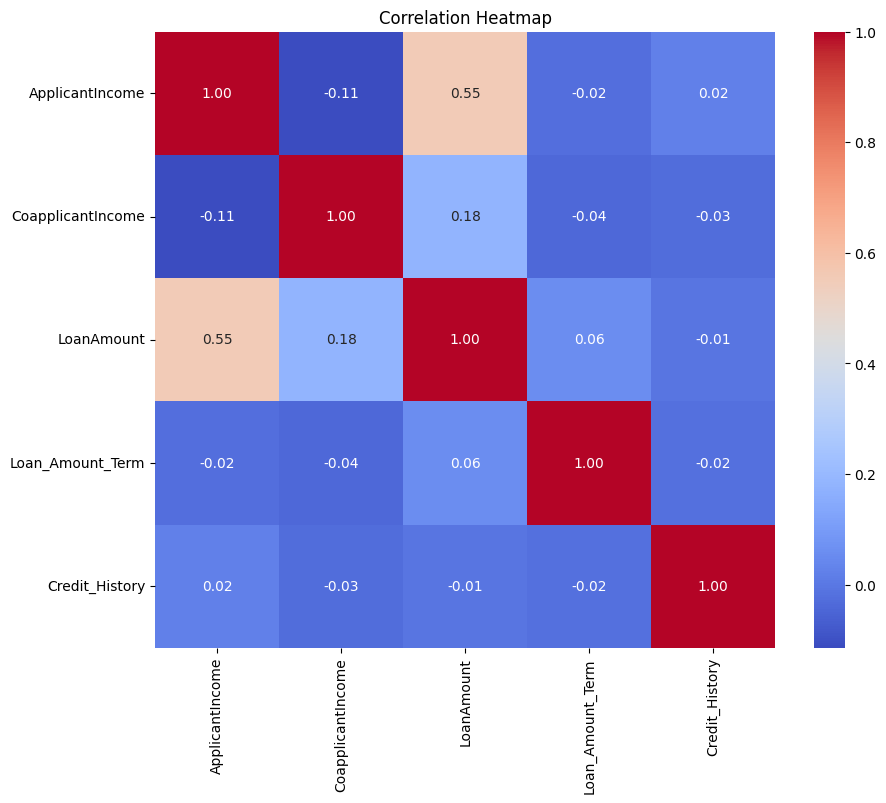

In [12]:
#correlation matrix
numeric_var = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Credit_History']
df_pandas = df.select(numeric_var).toPandas()

# Calculate the correlation matrix
correlation_matrix = df_pandas.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Therefore there is no multicollinearity betwen the numeric predictors

Text(0.5, 1.0, 'Loan_Status')

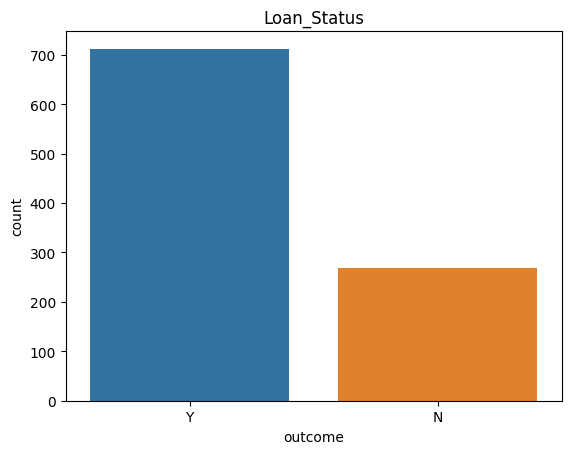

In [13]:
#countplot for the response variable
df_pandas_all = df.toPandas()
sns.countplot(x=df_pandas_all['outcome'])
plt.title("Loan_Status")

Therefore the dataset is imbalanced.

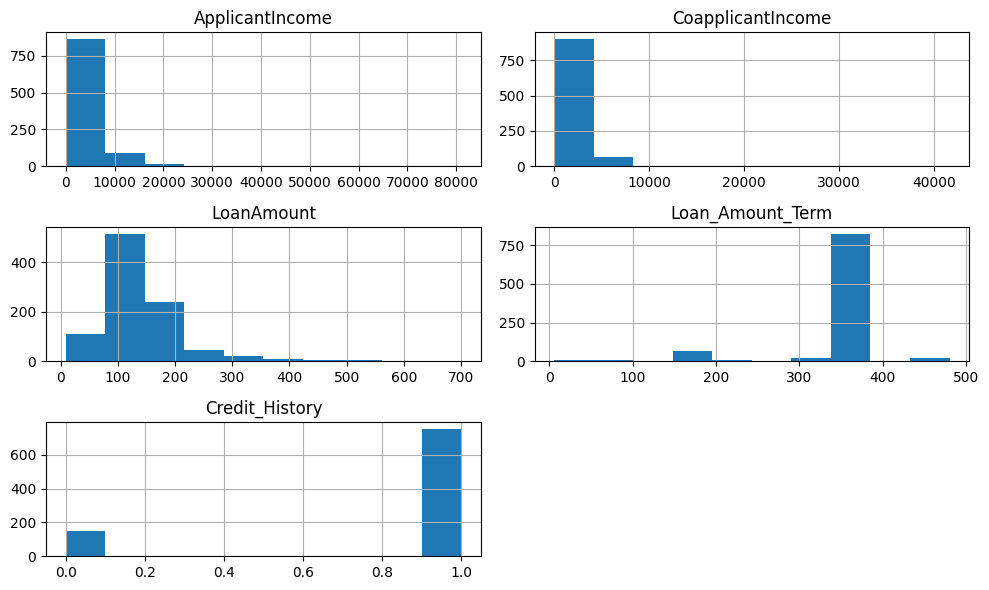

In [14]:
#histograms for numerical var
df_pandas.hist(figsize=(10, 6))
plt.tight_layout()
plt.show()

Therefore none of them are normally distributed.

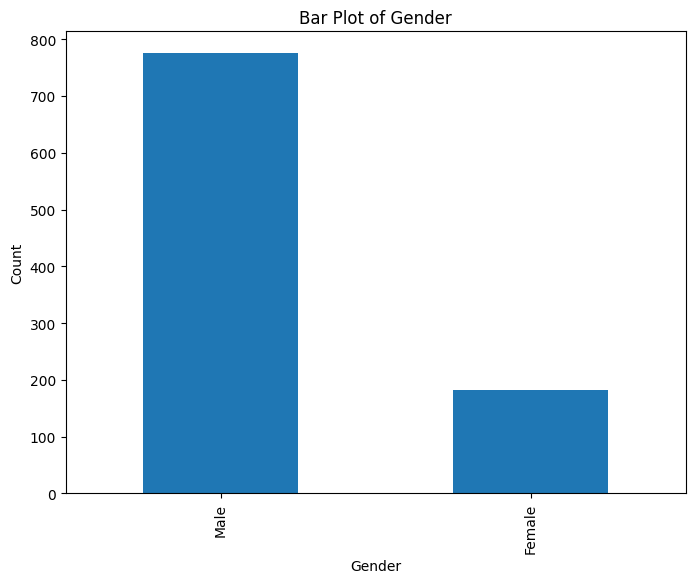

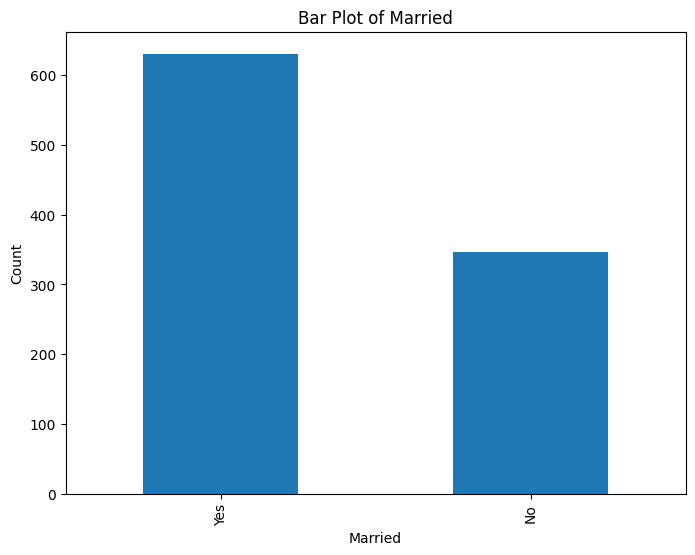

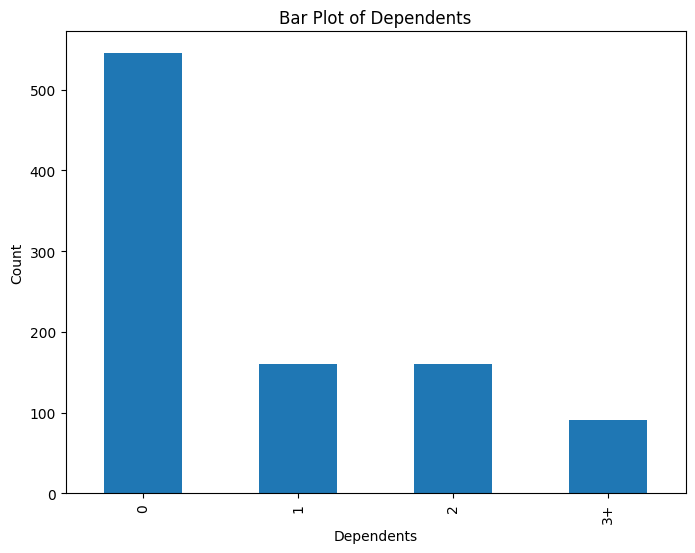

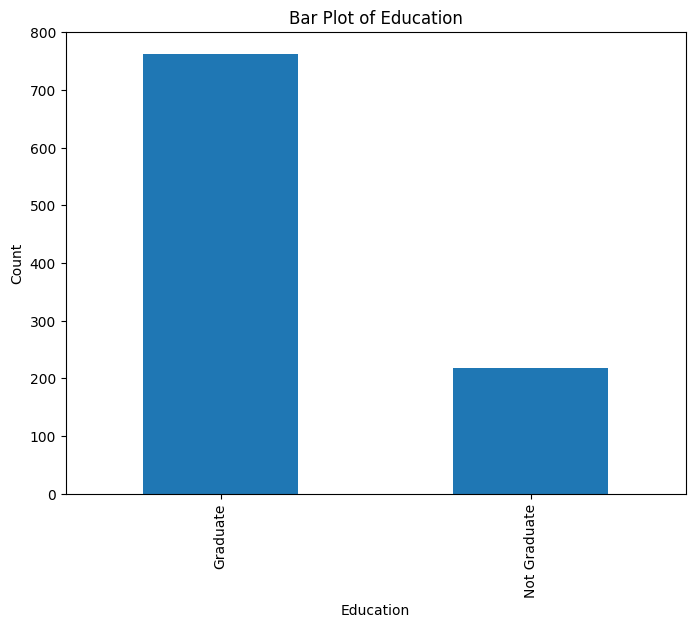

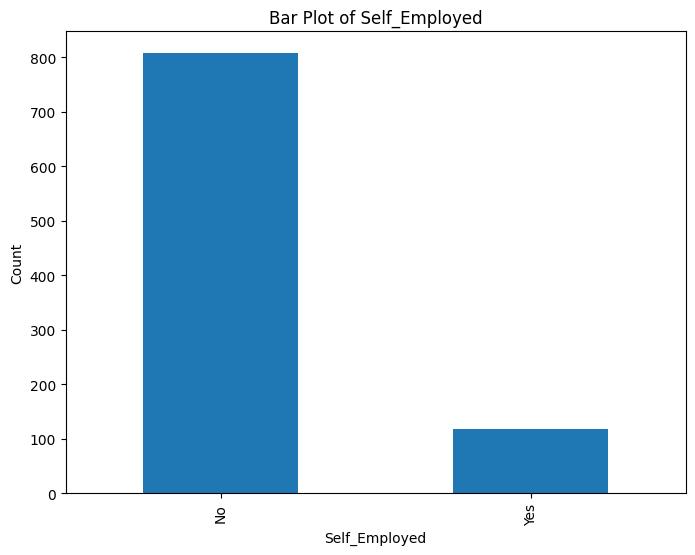

In [15]:
#countplots for categorical predictors
categorical_pred = ['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed']
df_pandas_categorical = df.select(categorical_pred).toPandas()

for i in categorical_pred:
  plt.figure(figsize=(8, 6))
  df_pandas_categorical[i].value_counts().plot(kind='bar')
  plt.title(f'Bar Plot of {i}')
  plt.xlabel(i)
  plt.ylabel('Count')
  plt.show()


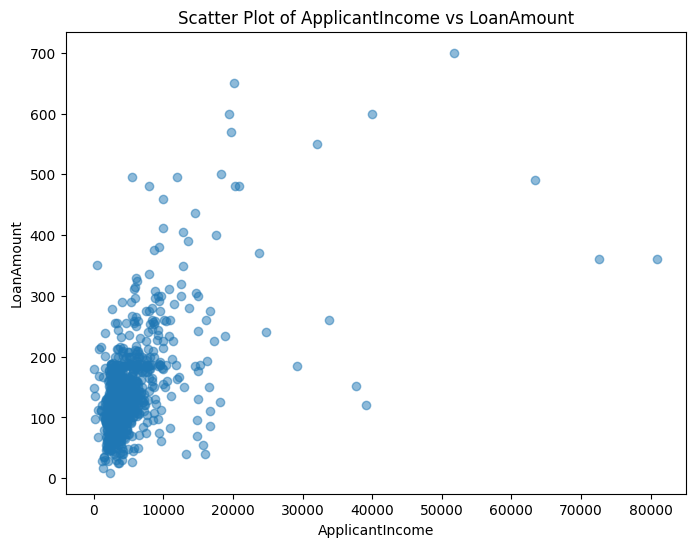

In [16]:
#Scatter plot
pandas_df = df.select(['ApplicantIncome','LoanAmount']).toPandas()

# Create scatter plot using matplotlib
plt.figure(figsize=(8, 6))
plt.scatter(pandas_df["ApplicantIncome"], pandas_df["LoanAmount"], alpha=0.5)
plt.title(f'Scatter Plot of ApplicantIncome vs LoanAmount')
plt.xlabel('ApplicantIncome')
plt.ylabel('LoanAmount')
plt.show()


Therefore as you can see when the applicant income is lower most of the time applicant loan amount also seems to be lower.

2).

In [17]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|outcome|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-------+
|      0|    24|      3|        25|        0|           55|              0|                0|        27|              20|            79|            0|      0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-------+



In [18]:
for column in df.columns:
    # Replacing blank values with NaN
    df = df.withColumn(column, when(col(column) == '', None).otherwise(col(column)))
    # Replacing integer value #N/A with NaN
    df = df.withColumn(column, when(col(column) == 'NaN', None).otherwise(col(column)))

In [19]:
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|outcome|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-------+
|      0|    24|      3|        25|        0|           55|              0|                0|        27|              20|            79|            0|      0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-------+



Therefore there are some missing values in some variables

In [20]:
#mode imputation
mode_columns = ["Gender", "Married", "Dependents", "Self_Employed", "Credit_History"]

for column in mode_columns:
    mode_val = df.groupBy(column).count().orderBy("count", ascending=False).first()[column]

    # Replacing the  missing values with the mode value
    df = df.withColumn(column, when(df[column].isNull(), mode_val).otherwise(df[column]))

In [21]:
mean_columns = ["Loan_Amount_Term","LoanAmount"]
# Initialize the Imputer
imputer = Imputer(
    inputCols= mean_columns,
    outputCols=mean_columns,
    strategy="mean"
)

model = imputer.fit(df)
df = model.transform(df)
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|outcome|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-------+
|      0|     0|      0|         0|        0|            0|              0|                0|         0|               0|             0|            0|      0|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-------+



No missing values

In [22]:
duplicated = df.join(
    df.groupBy(df.columns).agg(count("*").alias("count")),
    df.columns).filter(col("count") > 1).drop("count")
duplicated.show()

+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-------+
|Loan_ID|Gender|Married|Dependents|Education|Self_Employed|ApplicantIncome|CoapplicantIncome|LoanAmount|Loan_Amount_Term|Credit_History|Property_Area|outcome|
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-------+
+-------+------+-------+----------+---------+-------------+---------------+-----------------+----------+----------------+--------------+-------------+-------+



Therefore no duplicates

In [23]:
df.columns

['Loan_ID',
 'Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area',
 'outcome']

In [24]:
df = df.drop("Loan_ID")

In [25]:
df.columns

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'ApplicantIncome',
 'CoapplicantIncome',
 'LoanAmount',
 'Loan_Amount_Term',
 'Credit_History',
 'Property_Area',
 'outcome']

3)

In [26]:
train, test = df.randomSplit([0.7, 0.3], seed=1)

4)

In [27]:
categorical = ['Gender', 'Married','Dependents','Education','Self_Employed','Credit_History','Property_Area']

stringIndexer = StringIndexer(inputCols=categorical, outputCols=[x + "Index" for x in categorical])
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categorical])
labelToIndex = StringIndexer(inputCol="outcome", outputCol="label")

stringIndexerModel = stringIndexer.fit(train)
display(stringIndexerModel.transform(train))

DataFrame[Gender: string, Married: string, Dependents: string, Education: string, Self_Employed: string, ApplicantIncome: int, CoapplicantIncome: double, LoanAmount: int, Loan_Amount_Term: int, Credit_History: int, Property_Area: string, outcome: string, GenderIndex: double, MarriedIndex: double, DependentsIndex: double, EducationIndex: double, Self_EmployedIndex: double, Credit_HistoryIndex: double, Property_AreaIndex: double]

In [28]:
numeric_var = ["ApplicantIncome", "CoapplicantIncome", "LoanAmount", "Loan_Amount_Term"]
assemblerInputs = [c + "OHE" for c in categorical] + numeric_var
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

5)

In [29]:
lr_model = LogisticRegression(featuresCol="features", labelCol="label", regParam=1.0)

pipeline = Pipeline(stages=[stringIndexer, encoder,labelToIndex, vecAssembler, lr_model])

In [30]:
pipelineModel = pipeline.fit(train)

In [31]:
lr_pred = pipelineModel.transform(test)

In [32]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
accuracy = evaluator.evaluate(lr_pred, {evaluator.metricName: "areaUnderROC"})

print(f"Accuracy of the logistic regression model: {accuracy}")

Accuracy of the logistic regression model: 0.7497633782307979


Therefore model has an accuracy of 74.97%

In [33]:
lr_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_lr = lr_f1.evaluate(lr_pred)
print(f"F1-Score: {f1_lr}")

F1-Score: 0.6478141571093846


Therefore model has an accuracy of 64.78%

In [34]:
lr_auc = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
lr_auc = evaluator.evaluate(lr_pred)
print(f"Test AUC: {lr_auc}")

Test AUC: 0.7497633782307979


Therefore model has an accuracy of 74.97%

6)

7)

In [37]:
#random forest
rf_model = RandomForestClassifier(featuresCol='features', labelCol='label')

pipeline = Pipeline(stages=[stringIndexer, encoder,labelToIndex, vecAssembler, rf_model])
pipelineModel = pipeline.fit(train)
rf_pred = pipelineModel.transform(test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
accuracy_rf = evaluator.evaluate(rf_pred, {evaluator.metricName: "areaUnderROC"})

print(f"Accuracy of the random forest model: {accuracy_rf}")

rf_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_rf = rf_f1.evaluate(rf_pred)
print(f"F1-Score of the random forest model: {f1_rf}")

Accuracy of the random forest model: 0.767673825991991
F1-Score of the random forest model: 0.8633751122423357


Therefore model has an accuracy of 74.95% and f1 score of 86.33%

In [44]:
#decision tree
from pyspark.ml.classification import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(featuresCol='features', labelCol='label')

pipeline = Pipeline(stages=[stringIndexer, encoder,labelToIndex, vecAssembler, dt_model])
pipelineModel = pipeline.fit(train)
dt_pred = pipelineModel.transform(test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
accuracy_dt = evaluator.evaluate(dt_pred, {evaluator.metricName: "areaUnderROC"})

print(f"Accuracy of the DecisionTreeClassifier model: {accuracy_dt}")

dt_f1 = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_dt = dt_f1.evaluate(dt_pred)
print(f"F1-Score of the DecisionTreeClassifier model: {f1_dt}")

Accuracy of the DecisionTreeClassifier model: 0.4575900982890427
F1-Score of the DecisionTreeClassifier model: 0.8434366959453464


In [43]:
#Linear Support Vector Machine Classifier
svc_model = LinearSVC(featuresCol='features', labelCol='label')

pipeline = Pipeline(stages=[stringIndexer, encoder,labelToIndex, vecAssembler, svc_model])
pipelineModel = pipeline.fit(train)
svc_pred = pipelineModel.transform(test)

evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
accuracy_svc = evaluator.evaluate(svc_pred, {evaluator.metricName: "areaUnderROC"})

print(f"Accuracy of the Support Vector Machine Classifier model: {accuracy_svc}")

dt_svc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1_svc = dt_svc.evaluate(svc_pred)
print(f"F1-Score of the Support Vector Machine Classifier model: {f1_svc}")

Accuracy of the Support Vector Machine Classifier model: 0.7654896250455048
F1-Score of the Support Vector Machine Classifier model: 0.8633751122423357


Therefore model has an accuracy of 76.55% and f1 score of 86.33%

In [45]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [46]:
classifiers = [RandomForestClassifier(featuresCol='features', labelCol='label'),
               DecisionTreeClassifier(featuresCol='features', labelCol='label'),
               LinearSVC(featuresCol='features', labelCol='label')]
results = []

for classifier in classifiers:
    pipeline_with_classifier = Pipeline(stages=[stringIndexer, encoder, labelToIndex, vecAssembler, classifier])
    if isinstance(classifier, RandomForestClassifier):
        param_grid = ParamGridBuilder() \
            .addGrid(classifier.maxDepth, [5, 10, 15]) \
            .addGrid(classifier.numTrees, [20, 50, 100]) \
            .build()

    elif isinstance(classifier, DecisionTreeClassifier):
        param_grid = ParamGridBuilder() \
            .addGrid(classifier.maxDepth, [5, 10, 15]) \
            .build()
    elif isinstance(classifier, LinearSVC):
        param_grid = ParamGridBuilder() \
            .addGrid(classifier.maxIter, [10, 20, 30]) \
            .addGrid(classifier.regParam, [0.1, 0.01]) \
            .build()
    evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")


    crossval = CrossValidator(estimator=pipeline_with_classifier,
                              estimatorParamMaps=param_grid,
                              evaluator=evaluator,
                              numFolds=3,
                              parallelism=4)

     #choosing the best parameters
    cv_model = crossval.fit(train)


    best_pipeline_model = cv_model.bestModel


    predictions = best_pipeline_model.transform(test)
    auc = evaluator.evaluate(predictions)
    accuracy = MulticlassClassificationEvaluator(labelCol="label", metricName="accuracy").evaluate(predictions)
    precision = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedPrecision").evaluate(predictions)
    recall = MulticlassClassificationEvaluator(labelCol="label", metricName="weightedRecall").evaluate(predictions)
    f1 = MulticlassClassificationEvaluator(labelCol="label", metricName="f1").evaluate(predictions)


    results.append({
        "Classifier": classifier.__class__.__name__,
        "AUC": auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1
    })

#results
for result in results:
    print(f"Classifier: {result['Classifier']}")
    print(f"AUC: {result['AUC']}")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"Precision: {result['Precision']}")
    print(f"Recall: {result['Recall']}")
    print(f"F1-Score: {result['F1-Score']}")
    print("=" * 50)

Classifier: RandomForestClassifier
AUC: 0.802985074626867
Accuracy: 0.875
Precision: 0.8880198915009042
Recall: 0.875
F1-Score: 0.8599170437405732
Classifier: DecisionTreeClassifier
AUC: 0.729632326174008
Accuracy: 0.8161764705882353
Precision: 0.8053522313902937
Recall: 0.8161764705882353
F1-Score: 0.8071659434841016
Classifier: LinearSVC
AUC: 0.6994539497633788
Accuracy: 0.8786764705882353
Precision: 0.8954986406327237
Recall: 0.8786764705882353
F1-Score: 0.8633751122423357


Therefore the best test accuracy is :88.24% for the random Forest classifier

In [50]:
# Get the best parameter set
best_params = best_pipeline_model.stages[-1].extractParamMap()
best_params

{Param(parent='LinearSVC_be21371b1ca7', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearSVC_be21371b1ca7', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LinearSVC_be21371b1ca7', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearSVC_be21371b1ca7', name='labelCol', doc='label column name.'): 'label',
 Param(parent='LinearSVC_be21371b1ca7', name='maxBlockSizeInMB', doc='maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0.'): 0.0,
 Param(parent='LinearSVC_be21371b1ca7', name='maxIter', doc='max number of iterations (>= 0).'): 30,
 Param(parent='LinearSVC_be21371b1ca7', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='Linea